### **Busca na Internet com Tavily**

*Imports* e *setup* de chaves de API.

- Google Gemini API Key: https://aistudio.google.com/app/apikey?hl=pt-br
- Tavily API Key: https://app.tavily.com/home

Instalção das bibliotecas necessárias

In [ ]:
# !pip install -U -q langgraph langchain langchain-google-genai langchain_tavily

fish: Unknown command: pip
fish: 
pip install -U -q langgraph langchain langchain-google-genai langchain_tavily
^~^


In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
    if not os.environ.get("TAVILY_API_KEY"):
        os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY: ")
_set_env("GOOGLE_API_KEY")
_set_env("TAVILY_API_KEY")

Tavily é uma API de busca presente nas opções pré-cosntruîdas do LangChain

In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2) # instanciando o TavilySearch
tool.invoke("O que é um Agente de IA?") # query de pesquisa

{'query': 'O que é um Agente de IA?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aws.amazon.com/pt/what-is/ai-agents/',
   'title': 'O que são agentes de IA?',
   'content': 'Um agente de inteligência artificial (IA) é um programa de software que pode interagir com seu ambiente, coletar dados e usar os dados para realizar tarefas autodeterminadas para atingir metas predeterminadas. Em seguida, o agente de IA aplica os dados para tomar uma decisão informada. Enquanto isso, uma arquitetura que hospeda um agente de software de IA pode usar um prompt de texto, API e bancos de dados para permitir operações autônomas. Durante esse processo, o agente pode criar e atuar em mais tarefas para alcançar o resultado final. O Amazon Connect Contact Lens é um agente de IA autônomo que sua organização pode usar para gerenciar e gerar análises de centrais de atendimento em tempo real.',
   'score': 0.9549888,
   'raw_content': None},
  {'url': 'https://w

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0) # instanciando o modelo Gemini

In [5]:
# criando a função (tool) de busca online
def search_online(query:str) -> dict:
    """Ferramenta de busca online que
    utiliza o Tavily

    Args:
        query (str): requisição de pesquisa.
    """
    tool = TavilySearch(max_results=2)
    results = tool.invoke(query)
    return results

tools = [search_online]
llm_with_tools = llm.bind_tools(tools) # adicionando a função de busca online ao modelo Gemini

Criação do grafo

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

class State(MessagesState):
    # Adicione qualquer chave necessária além de messages
    pass

# Mensagem de sistema
sys_msg = SystemMessage(content='Você é um ajudante útil encarregado de fazer buscas online.')

# Nó
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

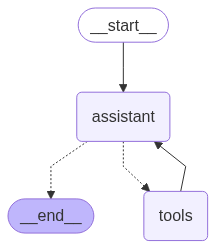

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Grafo
builder = StateGraph(MessagesState)

# Definição de nós
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Definição de arestas
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to end
    tools_condition,
)

builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Visualização
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="O que é langgraph")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

O que é langgraph
================================== Ai Message ==================================
Tool Calls:
  search_online (71c5933a-f65d-4860-9df9-ff3403717fb2)
 Call ID: 71c5933a-f65d-4860-9df9-ff3403717fb2
  Args:
    query: langgraph
================================= Tool Message =================================
Name: search_online

{"query": "langgraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allow